### Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv("data/water_potability.csv")

In [4]:
data.iloc[np.random.randint(0,len(data),10)]

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
1249,9.128358,184.682104,10418.108345,6.850200,388.068711,371.482308,10.444501,68.184020,3.762223,0
1389,9.395842,162.157700,9225.770911,8.275035,NaN,451.524629,12.632707,80.249886,3.530498,0
2201,5.486059,186.695632,16639.215179,9.807780,NaN,355.942431,12.254262,NaN,4.557707,0
2725,7.780869,221.844493,40483.730389,6.146098,302.329674,563.719967,11.753046,51.559465,4.602027,1
3252,4.868827,258.678959,13400.385532,4.880910,NaN,328.764529,17.352080,55.968217,3.255600,1
183,6.769573,168.937072,11067.181148,7.121264,305.794950,289.542460,18.545903,62.001571,5.220540,0
3052,6.155739,166.292920,30284.494869,8.995896,NaN,351.626734,17.404754,75.336207,3.685976,0
2497,8.005016,187.230535,49341.421279,4.339310,300.697128,437.325507,13.972014,NaN,5.288777,0
214,4.077608,207.838048,18194.954140,7.923974,NaN,288.365193,13.306692,35.824556,2.758659,0
988,NaN,190.630636,26913.373486,4.649166,302.417529,509.284869,16.198948,64.101951,3.452822,0


### Data Preprocessing
1. **Handling Missing Values**
   - The dataset contained missing values in 'Trihalomethanes', 'ph', and 'Sulfate'.
   - Rows with missing 'Trihalomethanes' were dropped and missing values in 'ph' and 'Sulfate' were imputed using median values.

In [5]:
# Dropping rows with missing 'Trihalomethanes' values
data_cleaned = data.dropna(subset=['Trihalomethanes'])

# Imputing missing values for 'ph' and 'sulfate' with their median values
data_cleaned['ph'].fillna(data_cleaned['ph'].median(), inplace=True)
data_cleaned['Sulfate'].fillna(data_cleaned['Sulfate'].median(), inplace=True)

# Checking the dataset after handling missing values
data_cleaned.isnull().sum()


ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

2. **Data Standardization**
   - Standardization was performed using `StandardScaler`. This step is crucial, especially for SVM, as it relies on calculating distances between data points. Standardizing ensures that all features contribute equally to the distance calculations.

In [6]:
# Splitting the dataset into features (X) and target (y)
X = data_cleaned.drop('Potability', axis=1)
y = data_cleaned['Potability']

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


3. **Feature Selection**
   - Initial feature selection involved removing features with low variance, under the assumption that features with lesser variance contribute less to the model's decision-making process.
   - Further, the top 5 features were selected using Random Forest Classifier, focusing on the features most correlated with the target variable. This helped in reducing the dimensionality of the data and potentially improving model performance.

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Feature Selection using RandomForestClassifier for feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Selecting features based on feature importance
selector = SelectFromModel(rf, prefit=True)
X_train_rf_selected = selector.transform(X_train_scaled)
X_test_rf_selected = selector.transform(X_test_scaled)

# Getting the selected feature names
selected_features_rf = X.columns[selector.get_support()]
selected_features_rf


Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate'], dtype='object')

### Model Training and Evaluation
1. **Model Selection**
   - **SVM Classifier**: Known for its effectiveness in high-dimensional spaces and versatility with kernel functions.
   - **Naive Bayes Classifier**: A probabilistic classifier that assumes feature independence, known for its simplicity and speed.

In [8]:
# Re-training the models using the features selected by RandomForest

# Training data with the newly selected features
X_train_rf = X_train_scaled[:, selector.get_support()]
X_test_rf = X_test_scaled[:, selector.get_support()]

# Re-initialize the models
svm_classifier_rf = SVC(probability=True)
nb_classifier_rf = GaussianNB()

# Re-train the models on the new set of features
svm_classifier_rf.fit(X_train_rf, y_train)
nb_classifier_rf.fit(X_train_rf, y_train)

# Re-evaluate the models
# Predictions for SVM
y_pred_svm_rf = svm_classifier_rf.predict(X_test_rf)
y_prob_svm_rf = svm_classifier_rf.predict_proba(X_test_rf)[:, 1] # Probability for ROC curve

# Predictions for Naive Bayes
y_pred_nb_rf = nb_classifier_rf.predict(X_test_rf)
y_prob_nb_rf = nb_classifier_rf.predict_proba(X_test_rf)[:, 1] # Probability for ROC curve

# Re-calculate evaluation metrics for SVM
conf_matrix_svm_rf = confusion_matrix(y_test, y_pred_svm_rf)
accuracy_svm_rf = accuracy_score(y_test, y_pred_svm_rf)
precision_svm_rf = precision_score(y_test, y_pred_svm_rf)
recall_svm_rf = recall_score(y_test, y_pred_svm_rf)
f1_score_svm_rf = f1_score(y_test, y_pred_svm_rf)
roc_auc_svm_rf = roc_auc_score(y_test, y_prob_svm_rf)

# Re-calculate evaluation metrics for Naive Bayes
conf_matrix_nb_rf = confusion_matrix(y_test, y_pred_nb_rf)
accuracy_nb_rf = accuracy_score(y_test, y_pred_nb_rf)
precision_nb_rf = precision_score(y_test, y_pred_nb_rf)
recall_nb_rf = recall_score(y_test, y_pred_nb_rf)
f1_score_nb_rf = f1_score(y_test, y_pred_nb_rf)
roc_auc_nb_rf = roc_auc_score(y_test, y_prob_nb_rf)

# Cross-validated misclassification rate for both models with new features
misclass_svm_rf = np.mean(cross_val_score(svm_classifier_rf, X_train_rf, y_train, cv=5, scoring='accuracy'))
misclass_nb_rf = np.mean(cross_val_score(nb_classifier_rf, X_train_rf, y_train, cv=5, scoring='accuracy'))

evaluation_results_rf = {
    'SVM': {
        'Confusion Matrix': conf_matrix_svm_rf,
        'Accuracy': accuracy_svm_rf,
        'Precision': precision_svm_rf,
        'Recall': recall_svm_rf,
        'F1 Score': f1_score_svm_rf,
        'ROC AUC': roc_auc_svm_rf,
        'Cross-validated Misclassification Rate': misclass_svm_rf
    },
    'Naive Bayes': {
        'Confusion Matrix': conf_matrix_nb_rf,
        'Accuracy': accuracy_nb_rf,
        'Precision': precision_nb_rf,
        'Recall': recall_nb_rf,
        'F1 Score': f1_score_nb_rf,
        'ROC AUC': roc_auc_nb_rf,
        'Cross-validated Misclassification Rate': misclass_nb_rf
    }
}



In [9]:
def plot_confusion_matrix_warm_colors(cm, title):
    """
    Helper function to plot the confusion matrix with a warm color scheme.
    """
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlOrRd", linewidths=0.5, linecolor='white')
    plt.title(f'Confusion Matrix for {title}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()



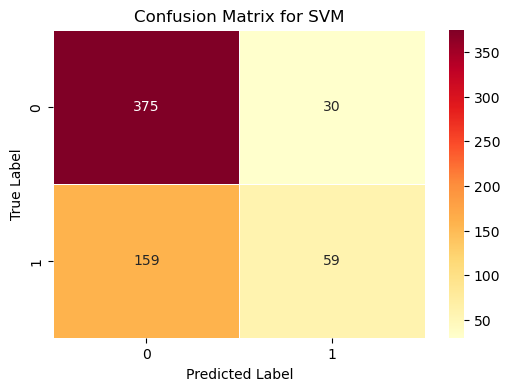

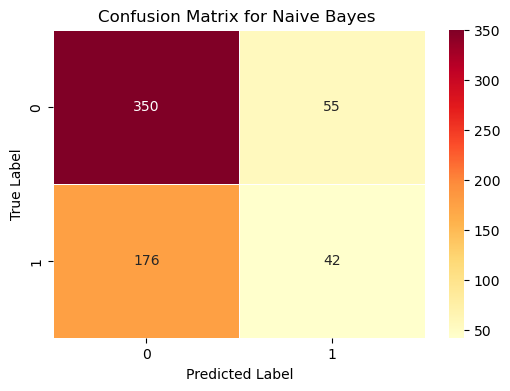

,SVM,Naive Bayes
Metric,,
Accuracy,0.696629,0.629213
Precision,0.662921,0.432990
Recall,0.270642,0.192661
F1 Score,0.384365,0.266667
ROC AUC,0.693561,0.564651
Cross-validated Misclassification Rate,0.693694,0.620637


In [10]:
# Creating a DataFrame for the new evaluation results
evaluation_df_rf = pd.DataFrame({
    'Metric': [ 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Cross-validated Misclassification Rate'],
    'SVM': [
        #evaluation_results_rf['SVM']['Confusion Matrix'], 
        evaluation_results_rf['SVM']['Accuracy'], 
        evaluation_results_rf['SVM']['Precision'], 
        evaluation_results_rf['SVM']['Recall'], 
        evaluation_results_rf['SVM']['F1 Score'], 
        evaluation_results_rf['SVM']['ROC AUC'], 
        evaluation_results_rf['SVM']['Cross-validated Misclassification Rate']
    ],
    'Naive Bayes': [
        #evaluation_results_rf['Naive Bayes']['Confusion Matrix'], 
        evaluation_results_rf['Naive Bayes']['Accuracy'], 
        evaluation_results_rf['Naive Bayes']['Precision'], 
        evaluation_results_rf['Naive Bayes']['Recall'], 
        evaluation_results_rf['Naive Bayes']['F1 Score'], 
        evaluation_results_rf['Naive Bayes']['ROC AUC'], 
        evaluation_results_rf['Naive Bayes']['Cross-validated Misclassification Rate']
    ]
})

evaluation_df_rf.set_index('Metric', inplace=True)

# Plotting confusion matrix for SVM with warm colors
plot_confusion_matrix_warm_colors(evaluation_results_rf['SVM']['Confusion Matrix'], "SVM")

# Plotting confusion matrix for Naive Bayes with warm colors
plot_confusion_matrix_warm_colors(evaluation_results_rf['Naive Bayes']['Confusion Matrix'], "Naive Bayes ")

evaluation_df_rf



In [16]:
print(  [evaluation_results_rf['Naive Bayes']['Accuracy'], 
        evaluation_results_rf['Naive Bayes']['Precision'], 
        evaluation_results_rf['Naive Bayes']['Recall'], 
        evaluation_results_rf['Naive Bayes']['F1 Score'], 
        evaluation_results_rf['Naive Bayes']['ROC AUC'], 
        evaluation_results_rf['Naive Bayes']['Cross-validated Misclassification Rate']])

[0.6292134831460674, 0.4329896907216495, 0.1926605504587156, 0.2666666666666667, 0.5646505833050175, 0.6206372584526483]


3. **Analysis of Results**
   - **SVM** outperformed Naive Bayes in terms of Accuracy and Precision. However, it had low Recall and F1 scores, indicating challenges in correctly identifying positive cases.
   - **Naive Bayes** showed lower performance across most metrics, which might be due to its assumption of feature independence, an assumption likely violated in this dataset.
   - Both models had moderate ROC AUC scores, suggesting moderate capability in distinguishing between classes.
   - Cross-validated Misclassification Rates were relatively high for both models, indicating a need for further model tuning or consideration of alternative models.
   
### Observations and Recommendations
1. **Class Imbalance and Complexity**: Both models struggled with class imbalance or the complexity of the dataset, as indicated by low Recall and F1 scores.
2. **Feature Engineering**: Further feature engineering or exploring non-linear relationships might enhance model performance.
3. **Model Complexity and Tuning**: SVM might benefit from hyperparameter tuning (like adjusting the C parameter or trying different kernels). For Naive Bayes, experimenting with different distributions might be useful.
4. **Alternative Models**: Given the moderate performance, exploring other models like Decision Trees, Random Forest, or Gradient Boosting might yield better results.
5. **Handling Imbalanced Data**: Techniques like SMOTE or adjusting class weights in the model could help in handling the class imbalance.

### Conclusion
The analysis revealed that while the SVM and Naive Bayes classifiers provide a baseline for understanding the dataset, there's significant room for improvement. Adjusting the data preprocessing steps, experimenting with different models and features, and specifically addressing the class imbalance could lead to more accurate and reliable predictions.

## SVM hyperparatmers

In [11]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

C = [1e-5,1e-4,1e-3,1e-2,1e-1,1e-0,1e1]

parameters = {'kernel':('linear', 'rbf','poly'), 'C':C}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train_rf, y_train)
clf.best_score_

0.694093407698932

In [12]:
clf.best_params_

{'C': 10.0, 'kernel': 'rbf'}

In [13]:
bestsvm = pd.DataFrame(clf.cv_results_)

In [14]:
bestsvm

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.028842,0.001053,0.007351,0.000099,0.00001,linear,"{'C': 1e-05, 'kernel': 'linear'}",0.597194,0.596386,0.596386,0.596386,0.596386,0.596547,0.000324,8
1,0.040564,0.000303,0.024200,0.000579,0.00001,rbf,"{'C': 1e-05, 'kernel': 'rbf'}",0.597194,0.596386,0.596386,0.596386,0.596386,0.596547,0.000324,8
2,0.034996,0.000442,0.008005,0.000297,0.00001,poly,"{'C': 1e-05, 'kernel': 'poly'}",0.597194,0.596386,0.596386,0.596386,0.596386,0.596547,0.000324,8
3,0.029111,0.000554,0.007666,0.000481,0.0001,linear,"{'C': 0.0001, 'kernel': 'linear'}",0.597194,0.596386,0.596386,0.596386,0.596386,0.596547,0.000324,8
4,0.040612,0.000334,0.026525,0.002920,0.0001,rbf,"{'C': 0.0001, 'kernel': 'rbf'}",0.597194,0.596386,0.596386,0.596386,0.596386,0.596547,0.000324,8
5,0.042957,0.000785,0.007893,0.000114,0.0001,poly,"{'C': 0.0001, 'kernel': 'poly'}",0.597194,0.596386,0.596386,0.596386,0.596386,0.596547,0.000324,8
6,0.028826,0.000227,0.007442,0.000027,0.001,linear,"{'C': 0.001, 'kernel': 'linear'}",0.597194,0.596386,0.596386,0.596386,0.596386,0.596547,0.000324,8
7,0.042573,0.000228,0.024206,0.000929,0.001,rbf,"{'C': 0.001, 'kernel': 'rbf'}",0.597194,0.596386,0.596386,0.596386,0.596386,0.596547,0.000324,8
8,0.046019,0.000682,0.007983,0.000161,0.001,poly,"{'C': 0.001, 'kernel': 'poly'}",0.597194,0.596386,0.596386,0.596386,0.596386,0.596547,0.000324,8
9,0.028848,0.000334,0.007466,0.000100,0.01,linear,"{'C': 0.01, 'kernel': 'linear'}",0.597194,0.596386,0.596386,0.596386,0.596386,0.596547,0.000324,8
